# Read in the data

In [2]:
import pandas
import numpy
import re
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
#print(correlations)

# Plot Correlations between the various survey fields and SAT scores

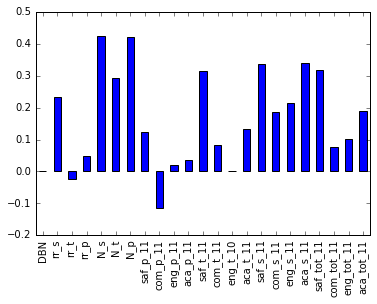

In [11]:
correlations[survey_fields].plot.bar()

The N_s, N_p, and N_t are all correlated with total enrolement, so it makes sense that they are high. Both the percieved saftey of the teachers (saf_t_11) and the students (saf_s_11) show strong, positive correlations. This makes sense as it is easier to both teach and learn in safer environments. The percieved academic standards of students correlates strongly while percieved academic standards for teachers or parents does not show this same correlation. It appears that the students drive is more important than the parent's or the teacher's.

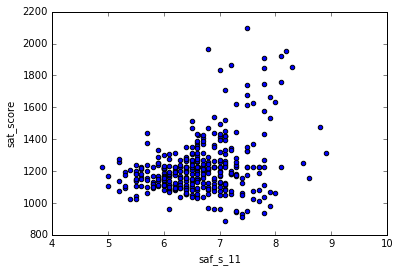

In [12]:
combined.plot.scatter('saf_s_11', 'sat_score')

In this scatterplot, you can see that high SAT scores (over 1600) really only happen after the student's percieved saftey was over 7. 

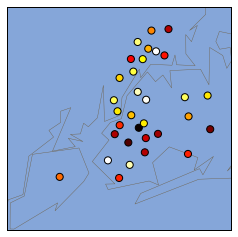

In [13]:
districts = combined.groupby('school_dist')
districts = districts.aggregate(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

latitudes = districts['lat'].tolist()
longitudes = districts['lon'].tolist()

m.scatter(longitudes, latitudes, s=50, zorder=5, 
          latlon=True, c=districts['saf_s_11'], cmap='hot')
plt.show()

Central Brooklyn can be seen to have a significantly higher level of percieved saftey than any of the surrounding bouroughs in NYC.

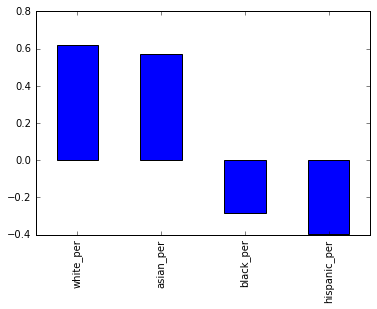

In [26]:
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

combined.corr()['sat_score'][race_cols].plot.bar()

These bar plots make the racial difference in SAT scores easiliy apparent to the readers. There is a very visible positive correlation for white and asain students, but but a very negative correlation for black and hispanic students. 

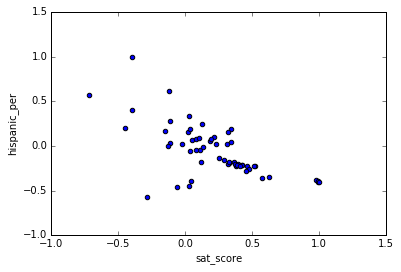

In [28]:
combined.corr().plot.scatter('sat_score', 'hispanic_per')

This scatterplot depicts a clear negative trend between the percentage of hispanics in the school and the average SAT score at that school. There is an exception of 4 schools that are in in the region of both low hispanic percentages and low SAT scores. 

In [29]:
print(combined['hispanic_per'].head())

0    53.8
1    45.9
2    55.4
3    56.9
4    14.2
Name: hispanic_per, dtype: float64


In [33]:
per_hisp_95 = combined[combined['hispanic_per'] > 95]
print(per_hisp_95['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Above is a list of all of the schools with 95% or greater hispanic populations. A little research shows that many of these schools are geared towards recent immigrants.

In [36]:
hisp_10_sat_1800 = combined[combined['hispanic_per'] < 10]
hisp_10_sat_1800 = hisp_10_sat_1800[hisp_10_sat_1800['sat_score'] > 1800]
print(hisp_10_sat_1800['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The above is a list of school names for schools that have less than 10% hispanic populations, but that also have SAT scores averaging over 1800. All of the schools that fall into this category are science add engineering preparatory schools.

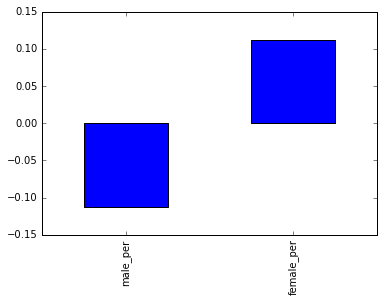

In [38]:
gender_scores = ['male_per', 'female_per']
combined.corr()['sat_score'][gender_scores].plot.bar()


The above bar plot shoes a clear discrepancy between the correlations of SAT scores to the male or female percentage of the student population. It does a good job of visually depicting how there is a definite split between male and female population percentages, but it lead to some misunderstandign of the data if the individual is not paying close attention to the r values on the y-axis. 

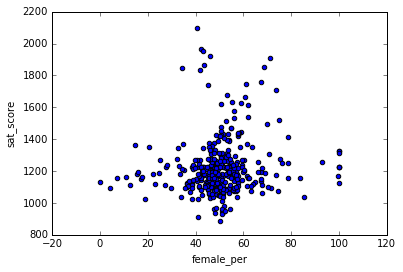

In [40]:
combined.plot.scatter('female_per', 'sat_score')

This scatterplot of the female percantage of schools against the aver SAT score depicts the weak correlation between the two variable. There is a small cluster of schools with a high percentage of female students as well as a high average SAT score

In [43]:
fem_60_sat_1700 = combined[combined['female_per'] > 60]
fem_60_sat_1700 = fem_60_sat_1700[fem_60_sat_1700['sat_score'] > 1700]
print(fem_60_sat_1700['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


All of the schools above have over 60% female students, and average SAT scores of over 1700. They all appear to be specialty liberalt arts schools which could explain the higher SAT scores due to higher academic standards.

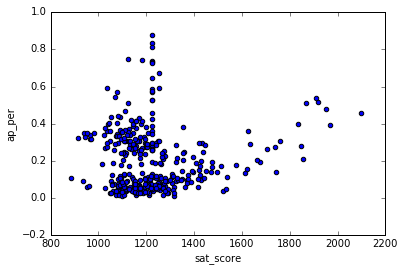

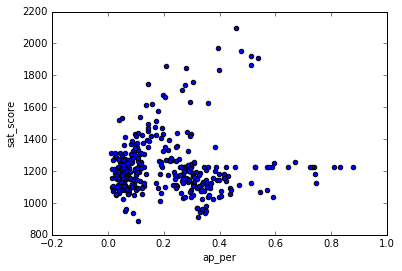

In [46]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

combined.plot.scatter('ap_per', 'sat_score')

A weak correlation between the SAT score and the percentage of students who took the AP test can be seen here. There seem to be two trends in this plot. One showing a strong relationship, and the other no relationship. Future analysis could be to investigate the differences between these two groups. 